# 순서
1. 목표 정의 및 개요
2. 탐색적 데이터 분석(EDA)
- 결측치, 이상치 확인
- 타겟 데이터와 피처 사이의 관계를 나타내는 그래프 그리기
3. 베이스라인 모델 생성
4. 성능 개선

## 1. 목표 정의 및 개요
- 목표 : 과거 사용 패턴과 날씨 데이터를 이용하여 시간별 자전거 대여 수요 예측
- 평가 기준 : RMSLE
- 제출 형식 : datetime, count(2011-01-20 00:00:00,0) 

## 2. 탐색적 데이터 분석(EDA)

### 2-1 데이터 불러오기

datetime - 시간별 날짜 + 타임스탬프     
season - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울     
holiday - 공휴일 여부(0 : 공휴일 아님, 1 : 공휴일)       
workingday - 근무일 여부(0 : 근무일 아님, 1 : 근무일)      
weather - 날씨       
1: 맑음, 약간 구름, 부분 흐림, 부분 흐림      
2: 안개 + 흐림, 안개 + 부서진 구름, 안개 + 약간 구름, 안개     
3: 가벼운 눈, 약한 비 + 뇌우 + 흩어진 구름, 약한 비 + 흩어진 구름         
4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개            
temp - 섭씨 온도     
atemp - 체감 섭씨 온도     
humidity - 상대습도     
windspeed- 풍속     
casual - 미등록 사용자 수     
registered - 등록 사용자 수    
count - 총 대여 수     

In [1]:
import numpy as np
import pandas as pd

file_path = 'C:/workspace/kaggle/bike_sharing_demand/data/'

train_data = pd.read_csv(file_path + 'train.csv')
test_data = pd.read_csv(file_path + 'test.csv')
submission_data = pd.read_csv(file_path + 'sampleSubmission.csv')

In [2]:
print(train_data.shape)
train_data.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
print(test_data.shape)
test_data.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


=> train_data에는 casual과 registered 피처 값이 존재하지만 test_data에는 해당 데이터가 없으므로 'casual','registered'데이터를 훈련 데이터에서 제거

#### train_data에서 casual, registered 컬럼 삭제

In [4]:
train_data = train_data.drop(['casual','registered'], axis=1)
train_data.shape

(10886, 10)

In [5]:
submission_data.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


### 2-2 결측치, 이상치 확인

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


=> train_data와 test_data에 결측치 없음

In [8]:
train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000


In [9]:
test_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [10]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


=> describe() 함수로 데이터 확인 시, 이상치 없음

## 3. 피처 엔지니어링 

### 3-1 날짜 데이터 핸들링

#### 날짜 데이터 쪼개기

In [11]:
train_data['datetime']

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [12]:
train_data['datetime'][0].split()[0].split('-')[0]

'2011'

In [13]:
train_data['year'] = train_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
train_data['month'] = train_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
train_data['day'] = train_data['datetime'].apply(lambda x: x.split()[0].split('-')[2])

train_data['hour'] = train_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
train_data['minute'] = train_data['datetime'].apply(lambda x: x.split()[1].split(':')[1])
train_data['second'] = train_data['datetime'].apply(lambda x: x.split()[1].split(':')[2])

In [14]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,01,01,00,00,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,01,01,01,00,00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,01,01,02,00,00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,01,01,03,00,00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,01,01,04,00,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,00,00
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,00,00
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,00,00
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,00,00


#### 요일 데이터 추가
- strptime : 날짜와 시간 형식의 문자열을 datetime으로 변환
- 요일의 경우 시간이 아닌 날짜만 고려하면 되므로 날짜만 있는 'date' 컬럼 추가

In [15]:
train_data['date'] = train_data['datetime'].apply(lambda x: x.split()[0])
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minute,second,date
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,01,01,00,00,00,2011-01-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,01,01,01,00,00,2011-01-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,01,01,02,00,00,2011-01-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,01,01,03,00,00,2011-01-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,01,01,04,00,00,2011-01-01


In [16]:
from datetime import datetime
import calendar

print(train_data['date'][0])
print(datetime.strptime(train_data['date'][0], "%Y-%m-%d"))

# 정수로 요일 반환
print(datetime.strptime(train_data['date'][0], "%Y-%m-%d").weekday())

2011-01-01
2011-01-01 00:00:00
5


#### weekday
- 월요일 : 0
- 일요일 : 6

In [17]:
print(calendar.day_name[datetime.strptime(train_data['date'][0], "%Y-%m-%d").weekday()])

Saturday


In [18]:
train_data['weekday'] = train_data['date'].apply(lambda x: calendar.day_name[datetime.strptime(x, "%Y-%m-%d").weekday()])

#### season과 weather 컬럼의 데이터를 문자열로 변환

season - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울       
weather - 날씨          
1: 맑음, 약간 구름, 부분 흐림, 부분 흐림        
2: 안개 + 흐림, 안개 + 부서진 구름, 안개 + 약간 구름, 안개        
3: 가벼운 눈, 약한 비 + 뇌우 + 흩어진 구름, 약한 비 + 흩어진 구름        
4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개        

In [19]:
train_data['season'] = train_data['season'].map({
                                                    1:'Spring',
                                                    2:'Summer',
                                                    3:'Fall',
                                                    4:'Winter'})

In [20]:
train_data['weather'] = train_data['weather'].map({1:'Clear',
                                                  2:'Mist, Few clouds',
                                                  3:'Light Snow, Rain, Thunderstorm',
                                                  4:'Heavy Rain, Thunderstorm, Snow, Fog'})

In [21]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minute,second,date,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,16,2011,01,01,00,00,00,2011-01-01,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,40,2011,01,01,01,00,00,2011-01-01,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,32,2011,01,01,02,00,00,2011-01-01,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,13,2011,01,01,03,00,00,2011-01-01,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,1,2011,01,01,04,00,00,2011-01-01,Saturday


- year, month, day 피처에 date 피처가 제공하는 모든 정보가 포함되어있음
- month 피처를 3달씩 묶을 경우 season(계절) 피처와 의미가 같아짐        
=> 세분화된 피처를 더 큰 분류로 묶을 경우 성능이 더 좋아지는 경우가 있음.      
   특정 피처가 다른 피처의 의미를 모두 포함하는 경우 의미가 중복되는 피처 삭제 필요(date, month)

In [22]:
# train_data = train_data.drop(['date','month'], axis=1)

In [23]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minute,second,date,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,16,2011,01,01,00,00,00,2011-01-01,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,40,2011,01,01,01,00,00,2011-01-01,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,32,2011,01,01,02,00,00,2011-01-01,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,13,2011,01,01,03,00,00,2011-01-01,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,1,2011,01,01,04,00,00,2011-01-01,Saturday


## 4. 데이터 시각화

In [24]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### 4-1 분포도

In [25]:
import warnings
warnings.filterwarnings('ignore')

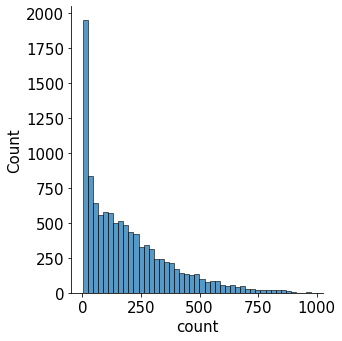

In [26]:
mpl.rc('font', size=15)
sns.displot(train_data['count'],kde=False)

- 타깃값의 분포가 왼쪽으로 편향됨
- 회귀 모델의 경우 데이터가 정규분포가 아닐 경우 좋은 성능이 나오지 않음        
=> **로그 변환**을 이용하여 편향된 데이터를 정규분포로 만들기

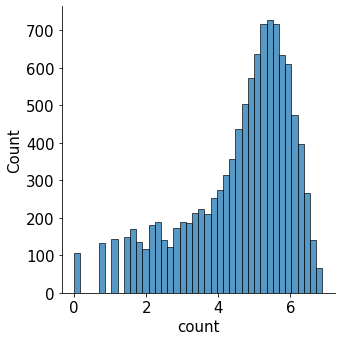

In [27]:
sns.displot(np.log(train_data['count']))

=> 예측 시, 타깃값을 로그 변환하여 사용하는게 더 좋은 성능을 낼 확률이 높음    
   예측을 한 후 마지막에 지수변환하여 count로 복원하는 작업이 필요

### 4-2 막대 그래프
- 연도, 월, 일, 시, 분, 초별로 평균 대여 수량을 막대 그래프로 그리기

<AxesSubplot:xlabel='year', ylabel='count'>

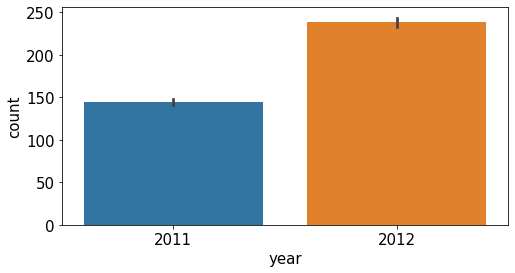

In [28]:
plt.figure(figsize=(8,4))
sns.barplot(train_data['year'],train_data['count'])

<AxesSubplot:xlabel='month', ylabel='count'>

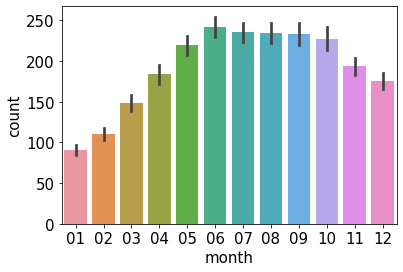

In [29]:
sns.barplot(train_data['month'],train_data['count'])

In [30]:
train_data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day',
       'hour', 'minute', 'second', 'date', 'weekday'],
      dtype='object')

#### subplots을 그리기 위한 Figure 준비

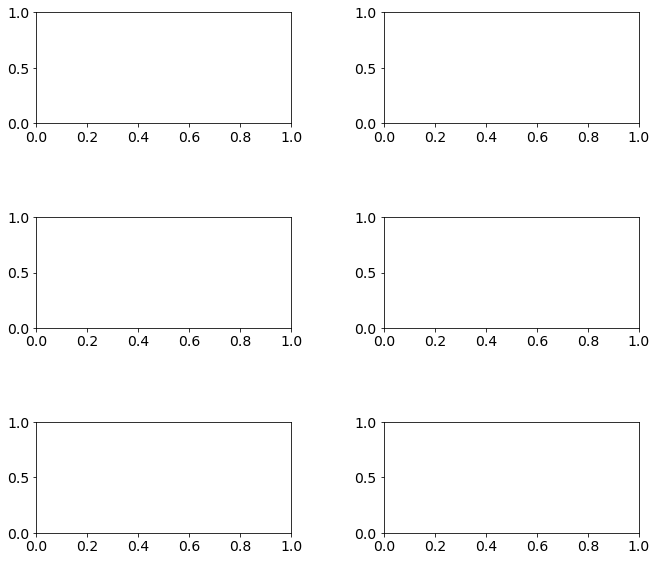

In [31]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=3, ncols=2)
plt.tight_layout()
figure.set_size_inches(10,9)

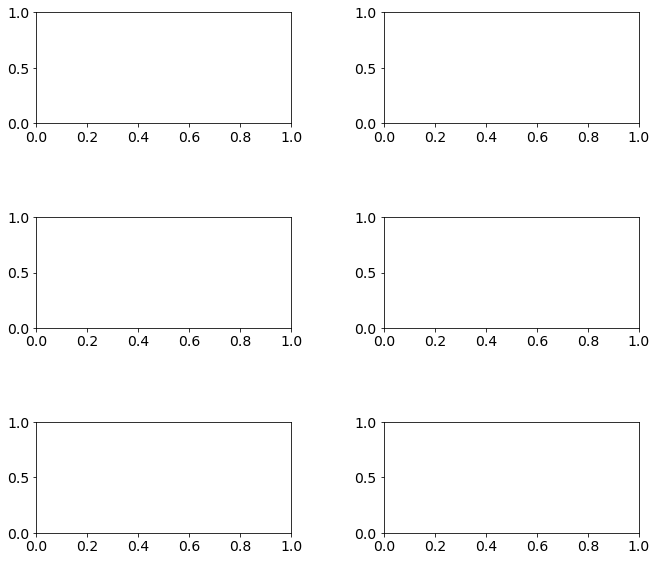

In [32]:
figure

In [33]:
axes

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

In [34]:
axes[0,0]

<AxesSubplot:>

#### 각 subplot에 그래프 할당

In [35]:
y_list = ['year', 'month', 'day', 'hour', 'minute', 'second']
index=0

for row in range(3):
    for col in range(2):
        sns.barplot(x=y_list[index], y='count', data=train_data, ax=axes[row, col])
        # 각 그래프에 제목 설정
        axes[row, col].set(title='Rental amounts by {0}'.format(y_list[index]))
        # x 값들의 글자들이 겹치므로 글자를 돌려주기
        if row == 1:
            axes[row, col].tick_params(axis='x', labelrotation=90)
        index += 1

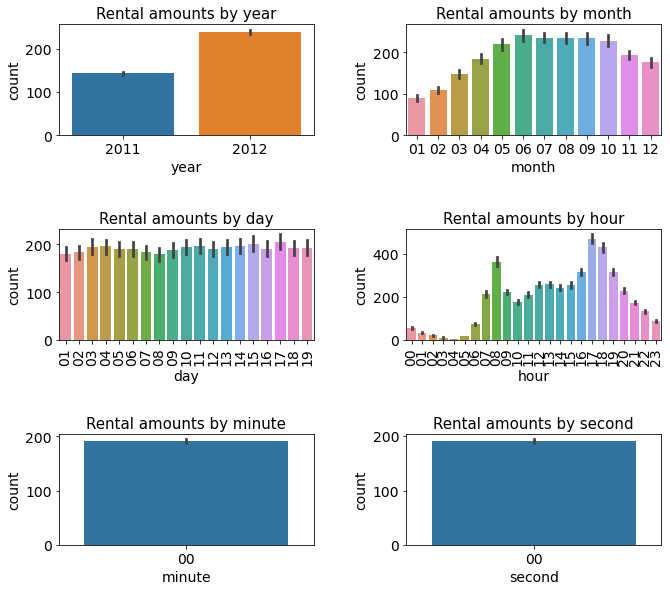

In [36]:
figure

- year : 2011년 보다 2012년에 대여수가 증가
- month : 6월 달이 대여수가 가장 많고, 1월이 대여수가 가장 적음 => 겨울이 다른 계절들에 비해 대여수가 적음
- day : 일별로는 대여수에 큰 차이가 없음. 훈련 데이터에는 1~19일까지만 존재, 테스트 데이터에는 20일부터 월말까지 있으므로 해당 컬럼은 제외
- hour : 아침8시와 저녁 17,18시에 대여수가 많음 => 다른 시간대에 비해 출퇴근 시간에 대여수가 많음
- minute, second : 값이 0밖에 없으므로 모델 훈련 시, 피처에서 제외        
=> 모델 훈련 시 day, minute, second 피처는 제외

### 4-3 박스 플롯
- 계절, 날씨, 공휴일, 근무일(범주형 데이터)별 대여 수량(수치형 데이터) 그리기

In [37]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minute,second,date,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,16,2011,01,01,00,00,00,2011-01-01,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,40,2011,01,01,01,00,00,2011-01-01,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,32,2011,01,01,02,00,00,2011-01-01,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,13,2011,01,01,03,00,00,2011-01-01,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,1,2011,01,01,04,00,00,2011-01-01,Saturday


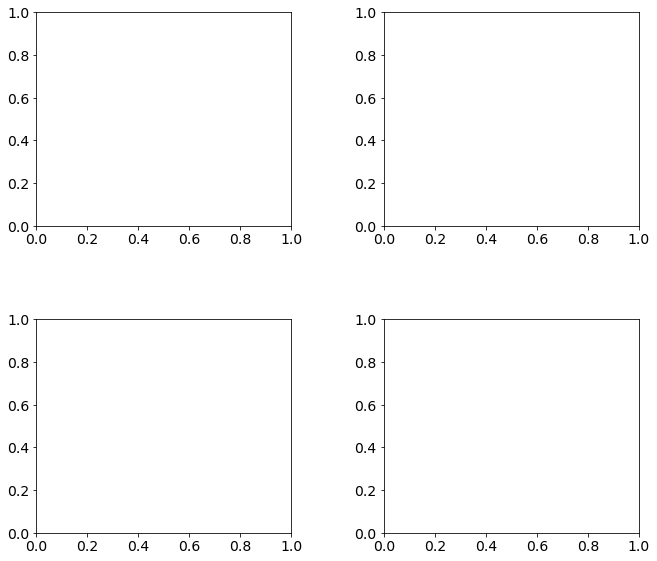

In [38]:
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
figure.set_size_inches(10,9)

In [39]:
train_data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day',
       'hour', 'minute', 'second', 'date', 'weekday'],
      dtype='object')

In [40]:
y_list = ['season', 'holiday', 'workingday', 'weather']
index=0

for row in range(2):
    for col in range(2):
        sns.boxplot(x=y_list[index], y='count', data=train_data, ax=axes[row, col])
        axes[row, col].set(title='Box Plot On Count Across {0}'.format(y_list[index]))
        index += 1
        
axes[1,1].tick_params(axis='x', labelrotation=10)

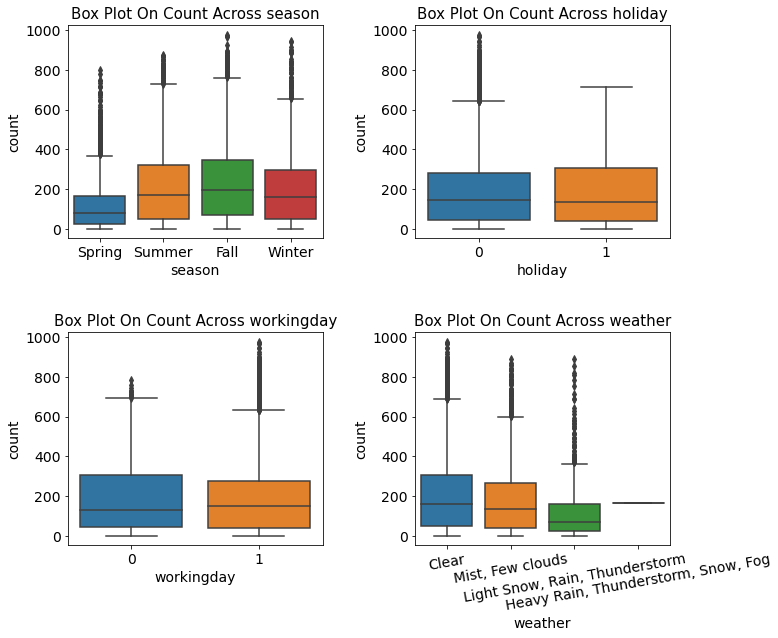

In [41]:
figure

- season : 봄에 비해 가을에 자전거 대여수가 많음 => 날씨가 따뜻할수록 대여수가 많아짐
- holiday, workingday : 공휴일, 근무일에 따라 대여수가 크게 차이나지 않음. 공휴일이 아닐 때, 근무일일 때 이상치가 많음
- weather : 날씨가 좋은 날에 대여수가 많음. 폭우, 폭설이 내리는 날엔 대여수가 거의 없음

### 4-4 포인트 플롯
- 범주형 데이터에 따라 수치형 데이터의 평균과 신뢰구간을 나타냄
- 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 그리기

In [42]:
train_data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day',
       'hour', 'minute', 'second', 'date', 'weekday'],
      dtype='object')

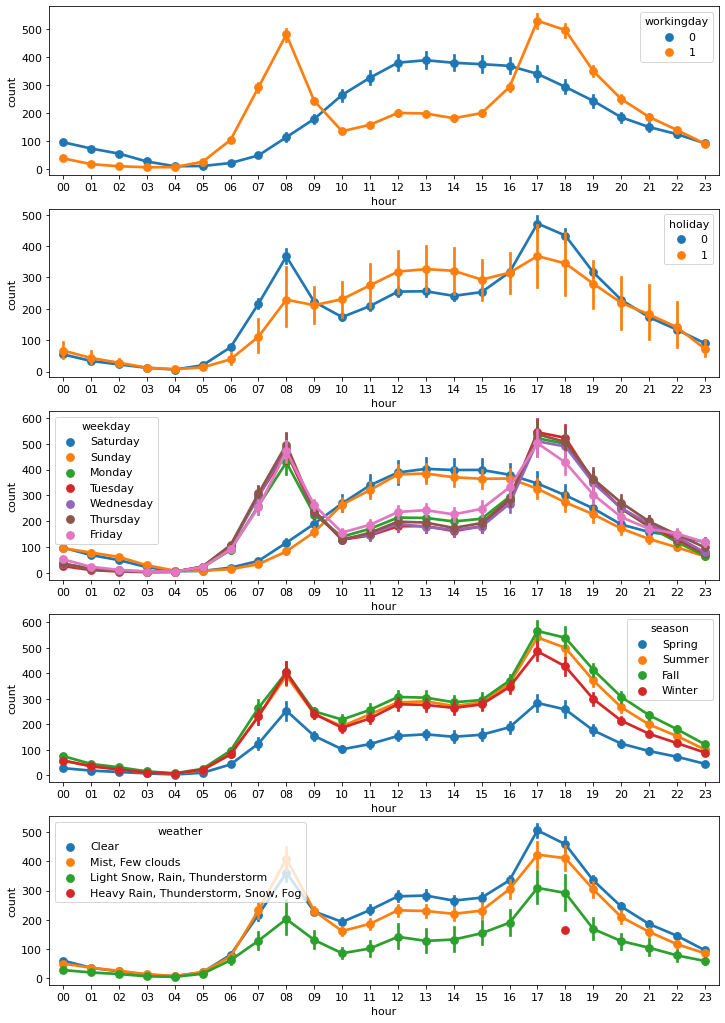

In [43]:
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5)
figure.set_size_inches(12,18)

y_list=['workingday','holiday','weekday','season','weather']
index=0

for row in range(5):
    sns.pointplot(x='hour', y='count',data=train_data, hue=y_list[index], ax=axes[index])
    index += 1

- season, weather : 계절과 날씨에 상관없이 8시와 17,18 시에 대여수가 높음
- workingday : 근무일에는 8, 17, 18시에 대여수가 많음. 반면 근무일이 아닌 경우 11~17까지 대여수가 많음
- holiday : 공휴일의 경우 대여수가 10 ~ 15시까지 공휴일이 아닌 날보다 많음
- weather에서 폭우, 폭설이 내린 날 18시에 대여 건수가 있음 => 이상치로 판단, 해당 데이터 제거

### 4-5 회귀선을 포함한 산점도 그래프
- 수치형 데이터인 온도, 체감 온도, 풍속, 습도별 대여 수량을 산점도 그래프로 그리기    
=> 수치형 데이터 간 상관관계를 파악하는데 사용

In [44]:
train_data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'year', 'month', 'day',
       'hour', 'minute', 'second', 'date', 'weekday'],
      dtype='object')

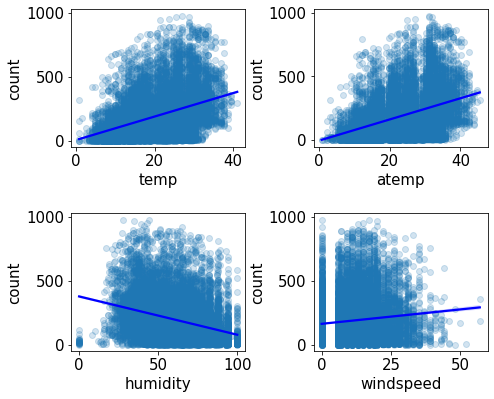

In [45]:
mpl.rc('font', size=15)
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
figure.set_size_inches(7,6)

y_list = ['temp', 'atemp', 'humidity', 'windspeed']
index=0

for row in range(2):
    for col in range(2):
        sns.regplot(x=y_list[index], y='count', data=train_data, ax=axes[row, col], scatter_kws={'alpha':0.2}, line_kws={'color':'blue'})
        index += 1


- temp, atemp : 온도와 체감온도의 경우 대여수와 양의 상관관계가 있음(비례) => 추울때보다 따뜻할 때 대여수가 더 많음
- humidity : 습도의 경우 대여수와 음의 상관관계가 있음(반비례) => 습도가 낮을수록 대여수가 더 많음
- windspeed : 0인 값이 많음 => 풍속이 0이 안닌 관측치가 없거나 오류로 인해 0으로 기록됐을 가능성이 높음    
=> windspeed 피처 제거

### 4-6 히트맵

In [46]:
train_data[['temp', 'atemp', 'humidity', 'windspeed','count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


[Text(0.5, 1.0, 'Heatmap of Numerical Data')]

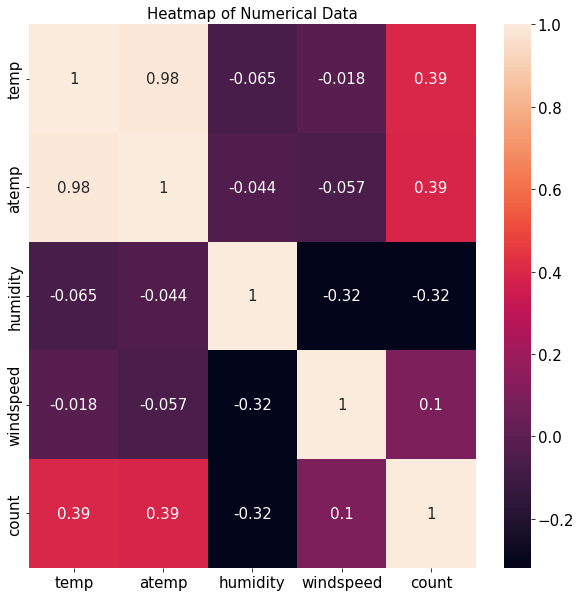

In [47]:
corrMat = train_data[['temp', 'atemp', 'humidity', 'windspeed','count']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
# annot=True : 상관계수가 숫자로 표시됨
sns.heatmap(corrMat, annot=True)
ax.set(title='Heatmap of Numerical Data')

## 5. 베이스라인 모델

 **베이스라인 모델 전체 프로세스**
- 데이터 불러오기 => 피처 엔지니어링 => 평가지표 계산 함수 작성 => 모델 훈련 => 성능 검증 => 제출

### 5-1 데이터 불러오기

In [48]:
file_path = 'C:/workspace/kaggle/bike_sharing_demand/data/'

train_data = pd.read_csv(file_path + 'train.csv')
test_data = pd.read_csv(file_path + 'test.csv')
submission_data = pd.read_csv(file_path + 'sampleSubmission.csv')

### 5-2 피처 엔지니어링
- 데이터를 변환
- 훈련 데이터와 테스트 데이터 공통으로 반영해야하므로 피처 엔지니어링 전에 두 데이터를 합친 후 피처 엔지니어링 후에 도로 나눠줌

#### 이상치 제거
- weather 데이터에서 폭설, 폭우에 해당하는 4인 값을 제거

In [49]:
train_data.shape

(10886, 12)

In [50]:
train_data = train_data[train_data['weather'] != 4]
train_data.shape

(10885, 12)

#### 데이터 합치기

In [51]:
print(train_data.shape)
train_data.head()

(10885, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [52]:
print(test_data.shape)
test_data.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [53]:
all_data_temp = pd.concat([train_data, test_data])
print(all_data_temp.shape)
all_data_temp.head()

(17378, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [54]:
all_data_temp.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN


In [55]:
all_data = pd.concat([train_data, test_data], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


#### 파생 피처(변수) 추가
- EDA 과정에서 생성했던 날짜 데이터와 관련된 파생 피처 추가
- year, month, hour, date, weekday 추가

In [56]:
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
all_data['weekday'] = all_data['date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d").weekday())

In [57]:
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,date,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,2011,01,00,2011-01-01,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,2011,01,01,2011-01-01,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,2011,01,02,2011-01-01,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,2011,01,03,2011-01-01,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,2011,01,04,2011-01-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012,12,19,2012-12-31,0
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012,12,20,2012-12-31,0
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012,12,21,2012-12-31,0
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,2012,12,22,2012-12-31,0


#### 필요 없는 피처 제거
- casual, registered, windspeed, date, month, datetime

In [58]:
all_data.shape

(17378, 17)

In [59]:
all_data = all_data.drop(['casual','registered','windspeed','date','month','datetime'], axis=1)
all_data.shape

(17378, 11)

#### 데이터 나누기

In [60]:
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train_data['count']

In [61]:
print(X_train.shape, y.shape)
print(X_test.shape)

(10885, 10) (10885,)
(6493, 10)


### 5-3 평가지표 계산 함수 작성
- RMSLE를 계산하는 함수

In [62]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

### 5-4 모델 훈련

In [63]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

log_y = np.log(y)
linear_reg_model.fit(X_train, log_y)

LinearRegression()

### 5-5 모델 성능 검증

In [64]:
preds = linear_reg_model.predict(X_train)

In [65]:
print(f'선형 회귀의 RMSLE 값 :{rmsle(log_y, preds, True):.4f}')

선형 회귀의 RMSLE 값 :1.0205


### 5-6 예측 및 결과 제출

In [66]:
linearreg_preds = linear_reg_model.predict(X_test)

submission_data['count'] = np.exp(linearreg_preds)
submission_data.to_csv('submission.csv',index=False)

## 6. 성능 개선1:릿지 회귀 모델

### 6-1 하이퍼파라미터 최적화
- 그리드서치(grid search)

#### 모델 생성

In [67]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

#### 그리드서치 객체 생성

In [68]:
ridge_params = {'max_iter':[3000], 'alpha':[0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

In [69]:
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,
                                     param_grid=ridge_params,
                                     scoring=rmsle_scorer,
                                     cv=5)

#### 그리드서치 수행

In [70]:
log_y = np.log(y)
gridsearch_ridge_model.fit(X_train, log_y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [71]:
print('최적 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


### 6-2 성능 검증

In [72]:
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)

print(f'릿지 회귀 RMSLE  값 : {rmsle(log_y, preds, True):.4f}')

릿지 회귀 RMSLE  값 : 1.0205


=> 회귀 모델과 성능이 크게 다르지 않음

## 7. 성능 개선2: 라쏘 회귀 모델

In [75]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()

lasso_alpha = 1/np.array([0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000])

lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                     param_grid=lasso_params,
                                     scoring=rmsle_scorer,
                                     cv=5)

log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


In [77]:
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

print(f'라쏘 회귀 RMSLE  값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE  값 : 1.0205


=> 릿지와 라쏘 회귀의 경우 과대적합이 조금 덜 한것을 제외하면 베이스라인 모델과 성능이 크게 다르지 않음

## 8. 성능 개선 3 : 랜덤 포레스트 회귀 모델

### 8-1 하이퍼파라미터 최적화(모델 훈련)

In [80]:
from sklearn.ensemble import RandomForestRegressor

randomforest_model = RandomForestRegressor()

rf_params = {'random_state':[42], 'n_estimators':[100,120,140,160,180,200]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                             param_grid=rf_params,
                                             scoring=rmsle_scorer,
                                             cv=5)

log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)
print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 180, 'random_state': 42}


### 8-2 모델 성능 검증

In [81]:
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1120


### 8-3 예측 및 결과 제출

#### 훈련 데이터와 테스트 데이터의 분포 비교
- 두 데이터의 분포가 비슷하면 과대적합 문제가 상대적으로 적음

Text(0.5, 1.0, 'Predicted Test Data Distribution')

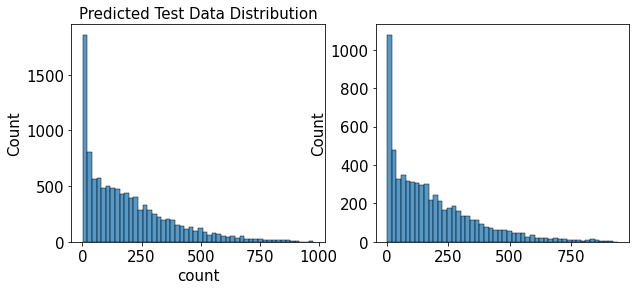

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10,4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[0].set_title('Predicted Test Data Distribution')

In [84]:
submission_data['count'] = np.exp(randomforest_preds)
submission_data.to_csv('submission.csv', index=False)